# Comparison of two approaches to efficient communication applied to modals

### Define the modals universe

In [2]:
from ultk.language.semantics import Referent, Universe
from ultk.effcomm.informativity import informativity
import numpy as np

universe = Universe.from_csv("./data/universe.csv")
universe

Universe(referents=(Referent(weak+epistemic, {'name': 'weak+epistemic', 'force': 'weak', 'flavor': 'epistemic', 'probability': 0.1389370306181398, '_frozen': True}), Referent(weak+deontic, {'name': 'weak+deontic', 'force': 'weak', 'flavor': 'deontic', 'probability': 0.0420277296360485, '_frozen': True}), Referent(weak+circumstantial, {'name': 'weak+circumstantial', 'force': 'weak', 'flavor': 'circumstantial', 'probability': 0.1429809358752166, '_frozen': True}), Referent(strong+epistemic, {'name': 'strong+epistemic', 'force': 'strong', 'flavor': 'epistemic', 'probability': 0.1042749855574812, '_frozen': True}), Referent(strong+deontic, {'name': 'strong+deontic', 'force': 'strong', 'flavor': 'deontic', 'probability': 0.2537550548815713, '_frozen': True}), Referent(strong+circumstantial, {'name': 'strong+circumstantial', 'force': 'strong', 'flavor': 'circumstantial', 'probability': 0.3180242634315424, '_frozen': True})), prior=(0.1389370306181398, 0.0420277296360485, 0.1429809358752166, 

### Define the measure of informativity

Using a 'half-credit' communictive utility scoring and a corpus-estimated prior over meanings

In [3]:
def half_credit_utility(m: Referent, m_: Referent) -> float:
    score = 0.0
    if m.force == m_.force:
        score += 0.5
    if m.flavor == m_.flavor:
        score += 0.5
    return score

modal_informativity = lambda lang: informativity(lang, universe.prior_numpy, half_credit_utility)

### Define complexity as length in a boolean grammar

In [4]:
from ultk.language.grammar import Grammar, GrammaticalExpression
from ultk.language.language import Expression, Meaning, Language, aggregate_expression_complexity

In [5]:
grammar = Grammar.from_yaml("./data/grammar.yaml")
grammar

expressions_by_meaning: dict[Meaning, Expression] = grammar.get_unique_expressions(
    depth=5,
    max_size=2 ** len(universe) + 1,
    unique_key=lambda expr: expr.evaluate(universe),
    compare_func=lambda e1, e2: len(e1) < len(e2),
)
expressions_by_meaning = {key: value for key, value in expressions_by_meaning.items() if not key.is_uniformly_false()} # exclude bottom

In [6]:
def complexity(
    language: Language, expressions_by_meaning: dict[Meaning, GrammaticalExpression]
) -> float:
    """Get complexity of a language via minimal expression length in LoT.

    Args:
        language: the Language to measure
        expressions_by_meaning: a dictionary with keys as `Meaning`s, that returns the shortest GrammaticalExpression which expresses that Meaning

    Returns:
        sum of the length of the shortest LoT expression for each meaning in the language
    """
    return aggregate_expression_complexity(
        language, lambda expr: len(expressions_by_meaning[expr.meaning])
    )

boolean_complexity = lambda lang: complexity(lang, expressions_by_meaning)

### Load natural languages

In [7]:

import os
import yaml
from typing import Any
import pandas as pd
from ultk.language.semantics import FrozenDict


ALLOWED_REFERENCE_TYPES = ["paper-journal", "elicitation"]
REFERENCE_GRAMMAR = "reference-grammar"
REFERENCE_TYPES = [REFERENCE_GRAMMAR] + ALLOWED_REFERENCE_TYPES
REFERENCE_TYPE_KEY = "Reference-type"
LANGUAGE_IS_COMPLETE_KEY = "Complete-language"
FAMILY_KEY = "Family"

METADATA_FN = "metadata.yml"
MODALS_FN = "modals.csv"


def process_can_express(val: Any, can_express: dict = {True: [1], False: ["?", 0]}):
    """For an observation of whether a modal can_express a force-flavor pair, interpret ? as 1.

    Note that the existence of ? in the csv confuses pandas, and causes the type of can_express to be str.

    Args:
        val: the value of the can_express column, possibly an int or str

    Returns:
        boolean representing 'yes' if the value should be interpreted as True, False otherwise
    """
    if isinstance(val, int):
        return val
    if val.isnumeric():
        return bool(int(val))

    # different results depending on interpretation of '?'
    if val in can_express[True]:
        return True
    return False


##########################################################################
# Load in languages
##########################################################################

language_data_dir = "data/natural_languages" #TODO: point to repo instead?
dirs = [
    x
    for x in os.listdir(language_data_dir)
    if os.path.isdir(os.path.join(language_data_dir, x))
]


dataframes = dict()
for dir in dirs:
    # Ensure that is one of allowed reference types
    dirpath = os.path.join(language_data_dir, dir)
    metadata_path = os.path.join(dirpath, METADATA_FN)

    with open(metadata_path, "r") as stream:
        metadata = yaml.safe_load(stream) # dict

    reference_type = metadata[REFERENCE_TYPE_KEY]
    # must be paper-journal or elicitation
    if reference_type in ALLOWED_REFERENCE_TYPES:
            modals_fn = os.path.join(dirpath, MODALS_FN)
            if FAMILY_KEY not in metadata:
                pass
                # breakpoint()
            data = {
                "df": pd.read_csv(modals_fn),
                # "family": metadata[FAMILY_KEY],
            }
            dataframes[dir] = data
    else:
        # Skip reference-grammar obtained data if incomplete.
        print(f"Data for {dir} is of type {reference_type}; skipping.")


Data for Qiang is of type reference-grammar; skipping.
Data for Donmari is of type reference-grammar; skipping.
Data for Nuosu is of type reference-grammar; skipping.
Data for Kwaza is of type reference-grammar; skipping.
Data for Hinuq is of type reference-grammar; skipping.
Data for Vaeakau-Taumako is of type reference-grammar; skipping.
Data for Mian is of type reference-grammar; skipping.
Data for Mani is of type reference-grammar; skipping.
Data for Tundra-Nenets is of type reference-grammar; skipping.
Data for Hup is of type reference-grammar; skipping.
Data for Jamul-Tipay is of type reference-grammar; skipping.
Data for Goemai is of type reference-grammar; skipping.


Convert dataframes to Languages

In [17]:
forces = set(ref.force for ref in universe)
flavors = set(ref.flavor for ref in universe)
forces, flavors

# Construct ModalLanguages for each natural language
experiment_languages: list[Language] = []
for language_name, data_dict in dataframes.items():
    print(f"Adding {language_name}")
    vocabulary = {}

    df = data_dict["df"]
    # family = data_dict["family"]
    # only look at positive polarity modals
    if "polarity" in df:
        df_positive = df[df["polarity"] == "positive"]
    else:
        df_positive = df

    # add each observation
    for _, row in df_positive.iterrows():
        modal = row["expression"]
        # initialize an expression's set of meanings
        if modal not in vocabulary:
            vocabulary[modal] = set()

        # Add only the flavors specified as possible for the experiment
        if (
            row["flavor"] in flavors
            and row["force"] in forces
        ):
            if process_can_express(row["can_express"]):
                observation = f"{row['force']}+{row['flavor']}"
                vocabulary[modal].add(observation)

    # Convert vocabulary into list of ModalExpressions

    experiment_vocabulary = []
    for modal in vocabulary:
        form = modal
        meaning = Meaning(
            mapping = FrozenDict(
                    {
                        referent: referent.name in vocabulary[modal]
                        for referent in universe
                    }
                ),
            universe = universe,
        )

        if meaning.is_uniformly_false(): # often there will be no usable referents due to can_express being False, above
            continue
        # search for a matching recorded meaning
        experiment_vocabulary.append(Expression(
            form,
            meaning,
        ))
    
    if experiment_vocabulary:
        lang = Language(expressions=experiment_vocabulary, name=language_name, natural=True)
        experiment_languages.append(lang)

Adding Dutch
Adding Korean
Adding Mapudungun
Adding Lillooet-Salish
Adding Vietnamese
Adding Hindi
Adding Japanese
Adding Thai
Adding Hungarian
Adding Mandarin
Adding Telugu
Adding Hausa
Adding Turkish
Adding Russian
Adding Tlingit
Adding Tagalog
Adding Greek
Adding Gitksan
Adding Hebrew
Adding Khmer
Adding Logoori
Adding Igbo
Adding Akan
Adding Kiitharaka
Adding Javanese-Paciran
Adding Cantonese
Adding Farsi
Adding Basque


### Measure languages

In [35]:
from tqdm import tqdm

def langs_to_df(languages: list[Language], properties_to_add: dict) -> pd.DataFrame:
    return pd.DataFrame.from_records(
        [
            {key: lang_dict[key] for key in properties_to_add} for lang_dict in 
            [
                language.as_dict_with_properties(
                    **{key: properties_to_add[key](idx, language) for key in properties_to_add}
                )
            for idx, language in tqdm(enumerate(languages), total=len(languages))
            ]
        ]
    )

In [89]:
natural_df = langs_to_df(
    experiment_languages,
    {
        "name": lambda _, lang: lang.name,
        "type": lambda _1, _2: "natural",
        "boolean_complexity": lambda _, lang: boolean_complexity(lang),
        "literal_informativity": lambda _, lang: modal_informativity(lang),
    }
)


100%|██████████| 28/28 [00:00<00:00, 1734.69it/s]


### Estimate pareto frontier

In [22]:
from ultk.effcomm.optimization import EvolutionaryOptimizer
from ultk.language.sampling import random_languages

In [27]:
expressions = list(expressions_by_meaning.values())

seed_languages = random_languages(
    expressions, sampling_strategy="stratified", sample_size=1000, max_size=10
)

# Evolutionary optimizer wants to minimize two objectives
objectives = [boolean_complexity, lambda lang: 1 - modal_informativity(lang)]

optimizer = EvolutionaryOptimizer(
    objectives,
    expressions,
    1000,
    3,
    50,
)
result = optimizer.fit(seed_languages)

100%|██████████| 50/50 [00:31<00:00,  1.57it/s]


In [90]:
dominating_df = langs_to_df(
    result["dominating_languages"], 
    {
        "name": lambda idx, _: f"dominating-{idx}",
        "type": lambda _1, _2: "dominant",
        "boolean_complexity": lambda _, lang: boolean_complexity(lang),
        "literal_informativity": lambda _, lang: modal_informativity(lang),
    },    
)

explored_df = langs_to_df(
    result["explored_languages"],
    {
        "name": lambda idx, _: f"explored-{idx}",
        "type": lambda _1, _2: "explored",
        "boolean_complexity": lambda _, lang: boolean_complexity(lang),
        "literal_informativity": lambda _, lang: modal_informativity(lang),
    },
)

100%|██████████| 15770/15770 [00:11<00:00, 1391.56it/s]


## Information Bottleneck analysis

Define the domain distribution $p(U|M)$ and $p(M)$

In [41]:
from ultk.effcomm.ib import select_gamma, pU_M_from_similarity, get_ib_naming_model

In [66]:
similarity_matrix = np.array([[half_credit_utility(m, m_) for m_ in universe] for m in universe])
pM = universe.prior_numpy

# Here we use an arbitrary value of gamma for parameterizing a similarity-based distributions that will produce a nontrivial bound
pU_M = pU_M_from_similarity(1e-1, similarity_matrix)

In [47]:
betas = np.logspace(0, 5, 1000,)
naming_model = get_ib_naming_model(
    pU_M, pM, betas=betas,
)

beta=1.00000: 100%|██████████| 1000/1000 [01:25<00:00, 11.74it/s]    


#### Define the mapping between a Language and an IB encoder

In [ ]:
def lang_to_encoder(language: Language) -> np.ndarray:
    """Simplifying assumption here that p(w) is uniform."""
    pM_W = []
    for expression in language.expressions:
        pm_w = list(expression.meaning.dist.values())
        pM_W.append(pm_w)
    pM_W = np.array(pM_W)
    z = pM_W.T.sum(axis=1, keepdims=True)
    # pW_M = np.where(z > 0, pM_W.T / z, np.zeros_like(len(language)))
    pW_M = pM_W.T / z
    return pW_M

In [76]:
natural_encoders = [lang_to_encoder(lang) for lang in tqdm(experiment_languages)]
dominating_encoders = [lang_to_encoder(lang) for lang in tqdm(result["dominating_languages"])]
explored_encoders = [lang_to_encoder(lang) for lang in tqdm(result["explored_languages"])]

100%|██████████| 15770/15770 [00:01<00:00, 10647.33it/s]


Measure natural languages on information plane

In [91]:
def add_ib_plane_columns(df: pd.DataFrame, encoders: list[np.ndarray]) -> pd.DataFrame:
    df["ib_complexity"], df["ib_accuracy"] = np.array([(naming_model.complexity(enc), naming_model.accuracy(enc)) for enc in tqdm(encoders)]).T
    return df


natural_df = add_ib_plane_columns(natural_df, natural_encoders)
dominating_df = add_ib_plane_columns(dominating_df, dominating_encoders)
explored_df = add_ib_plane_columns(explored_df, explored_encoders)

100%|██████████| 15770/15770 [00:01<00:00, 11843.19it/s]


In [100]:
# Lastly, load a dataframe of the ib bound.
ib_bound_df = pd.DataFrame(naming_model.IB_curve.T, columns=["ib_complexity","ib_accuracy"])

## Compare with visualizations

In [84]:
import plotnine as pn

#### boolean complexity vs. literal informativity

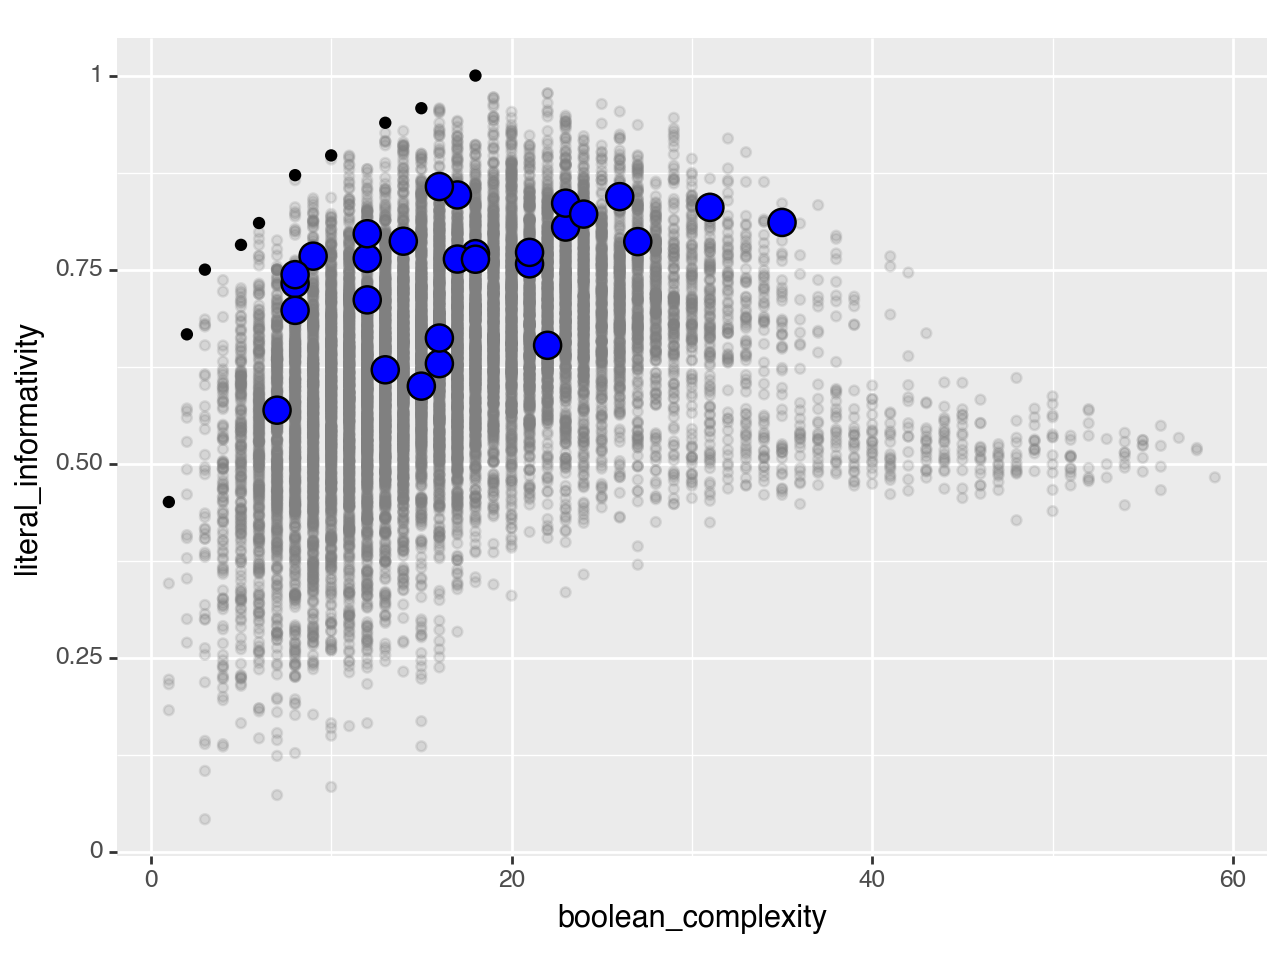

<Figure Size: (640 x 480)>

In [96]:
(
    pn.ggplot(
        natural_df,
        pn.aes(
            x="boolean_complexity",
            y="literal_informativity",
        ),
    )
    + pn.geom_point(
        explored_df,
        color="gray",
        alpha=0.2,
    )
    + pn.geom_point(
        fill="blue",
        size=5,
    )
    + pn.geom_point(
        dominating_df,
        color="black",
    )    
)

#### IB

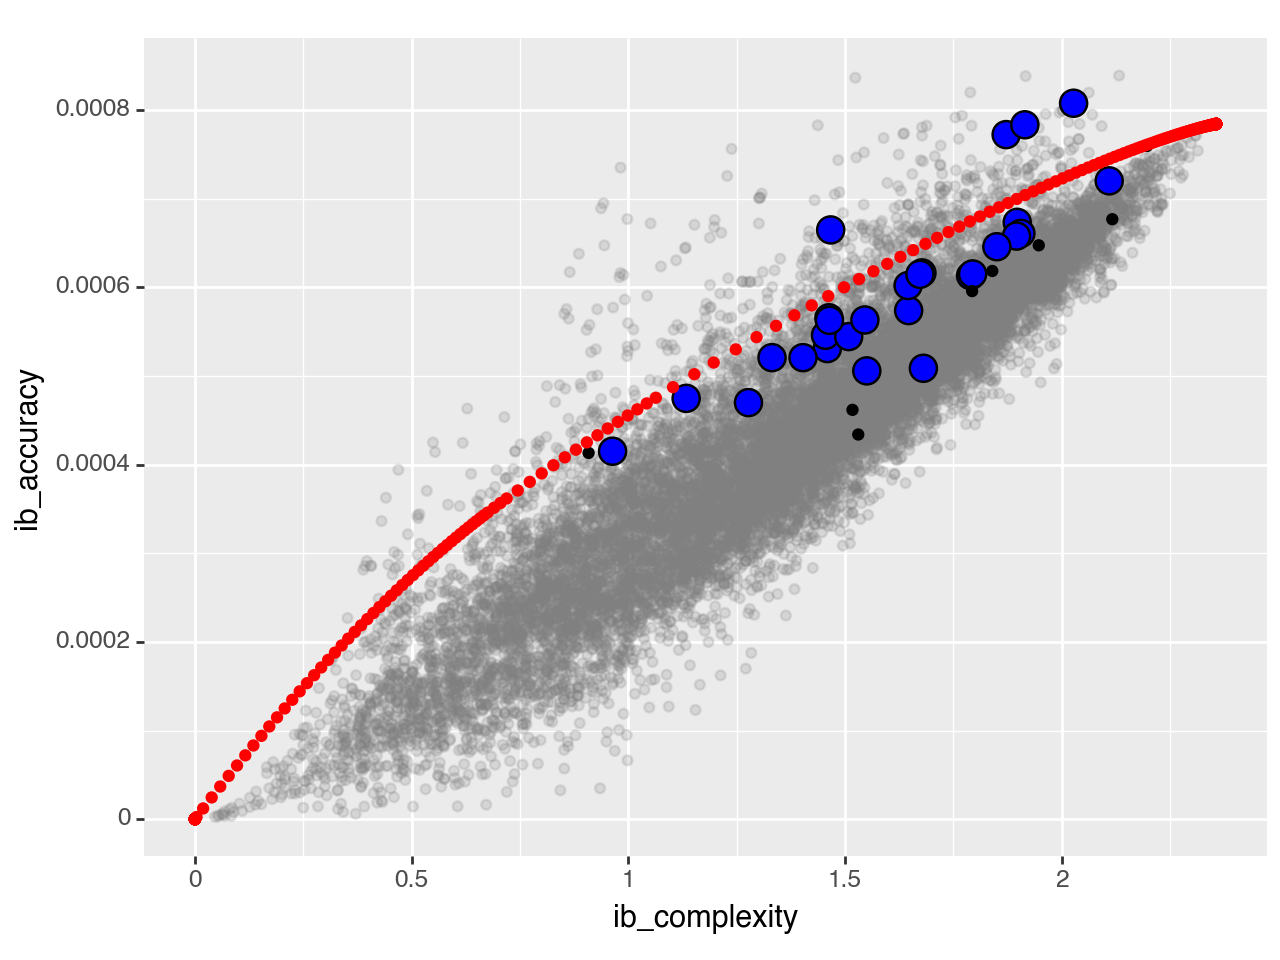

<Figure Size: (640 x 480)>

In [102]:
(
    pn.ggplot(
        natural_df,
        pn.aes(
            x="ib_complexity",
            y="ib_accuracy",
        ),
    )
    + pn.geom_point(
        explored_df,
        color="gray",
        alpha=0.2,
    )
    + pn.geom_point(
        fill="blue",
        size=5,
    )
    + pn.geom_point(
        dominating_df,
        color="black",
    )    
    + pn.geom_point(
        ib_bound_df,
        color="red",
    )
)